# Filtrado colaborativo

El filtrado colaborativo es una familia de aproximaciones algorítmicas basadas en el comportamiento colaborativo y colectivo. Esto permite realizar una definición a futuro de posibles feedback esperado bajo la matríz de ratings. Podemos encontrar filtrados basados en la similitud entre usuarios (User Based Collaborative Filtering) o basado en ítems (Item Based Colaborative Filtering).

El filtrado colaborativo basado en usuarios es el predecesor de los basados en ítems. Este permite encontrar usuarios similares basado en la información disponible sobre estos recomendando artículos consumidos por usuarios similares y que no hayan sido consumidos por el sujeto inicial.

## Conjunto de datos: Movielens

In [1]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from urllib.request import urlretrieve
# Dataset
urlretrieve("https://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
info = zip_ref.read('ml-100k/u.info')

# Users
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

# Movies
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Obtenemos el año de la fecha de publicación
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])

# Ratings
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

Aunque potente, existen ciertos problemas identificados en este tipo de sistemas.

*   Escalabilidad (scalability), debido al volumen del conjunto de datos y metodologías empleadas. Poder entrenar modelos o disponer de la memoria suficiente para gestionar el volumen de datos puede resultar un reto.

*   Escasez (sparsity) debido a que en la mayoría de sistemas son unos pocos usuarios los que generan el contenido haciendo dificil generalizar cuendo no se cuenta con suficiente información del grupo de usuarios.

Podemos analizar cómo se distribuyen los ratings por usuario y por ítem de cara a entender la dsitribución de los datos.

<AxesSubplot:>

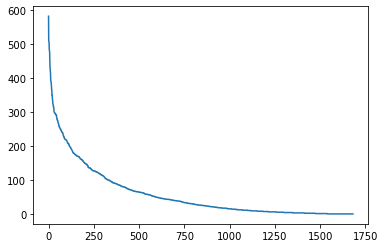

In [2]:
df = ratings.groupby('movie_id')["rating"].count().sort_values(ascending=False)
x = range(len(df))
y = df.tolist()
sns.lineplot(x=x, y=y)

In [3]:
ratings.groupby('movie_id')["rating"].count().sort_values(ascending=False)[:1000]

movie_id
50      583
258     509
100     508
181     507
294     485
       ... 
1071     16
454      16
725      16
453      16
1311     16
Name: rating, Length: 1000, dtype: int64

Podemos ver que existen bloques de películas con muchas más puntuaciones que otras con lo que nuestras recomendaciones pueden verse afectadas por ese sesgo. Y sucede de identica manera si evaluamos cómo de activos son los usuarios aportando su feedback.

### Ejercicio

Ejercicio: Evaluemos si sucede algo similar con los usuarios (unos pocos usuarios activos)


<AxesSubplot:>

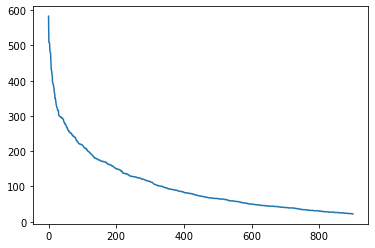

In [4]:
df = df[:900]
x = range(len(df))
y = df.tolist()
sns.lineplot(x=x, y=y)

Si nuestro sistema sufre de una o ambas problemáticas, su efectividad puede verse impactada (Sarwar et al.,2001) generando desconfianza en las recomendaciones generadas y alterando la experiencia de los usuarios.

En los sistemas iniciales donde la disparidad de productos era menor y con mayor contexto se optó por utilizar sistemas de recomendación basado en la similitud de los items (inicialmente propuesto por Amazon y adoptado por otras plataformas (Netflix, Youtube, etc.). Estos recomendadores permiten comparar items y ofrecer aquellos similares a items previamente consumidos por el usuario (y sobre los que tengamos un feedback o rating positivo).

# Matriz de ratings

Es el corazón de los sistemas de recomendación basados en filtros colaborativos. Encapsula todo el conocimiento que disponemos en lo que respecta a la interacción y satisfacción entre usuarios e ítems. Podemos construir nuestra martriz pero deberemos tener en cuenta que muchos pares item-usuario seguramente no cuenten con la información necesaria (no lo han visto o puntuado, no disponemos de feedback en esa celda).

In [5]:
ratings.pivot('user_id','movie_id','rating')

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Deberemos tomar una decisión "ejecutiva" de cómo tratar estos campos. Podemos emplear distintas estrategias (imputación de medias, imputación de ceros,...) pero dada la escasez de información es dificil disponer de suficiente soporte estadístico como para que cualquiera de estas estrategias no introduzca un alto nivel de ruido en cada caso.

Probemos con una aproximación sencilla de inputación de ceros.

### Ejercicio
Ejercicio: Rellenaremos con zeros los elementos no numéricos (not a number).


In [6]:
user_item_m = ratings.pivot('user_id','movie_id','rating')
user_item_m.fillna(0,inplace=True)
user_item_m

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## User Based Collaborative Filtering 

Esta es la matríz que emplearemos para evaluar la similitud entre usuarios (usuarios que opinan parecido).

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
X_user = cosine_similarity(user_item_m)
X_user
dfX_user = pd.DataFrame(X_user)

In [8]:
dfX_user

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,1.000000,0.166931,0.047460,0.064358,0.378475,0.430239,0.440367,0.319072,0.078138,0.376544,...,0.369527,0.119482,0.274876,0.189705,0.197326,0.118095,0.314072,0.148617,0.179508,0.398175
1,0.166931,1.000000,0.110591,0.178121,0.072979,0.245843,0.107328,0.103344,0.161048,0.159862,...,0.156986,0.307942,0.358789,0.424046,0.319889,0.228583,0.226790,0.161485,0.172268,0.105798
2,0.047460,0.110591,1.000000,0.344151,0.021245,0.072415,0.066137,0.083060,0.061040,0.065151,...,0.031875,0.042753,0.163829,0.069038,0.124245,0.026271,0.161890,0.101243,0.133416,0.026556
3,0.064358,0.178121,0.344151,1.000000,0.031804,0.068044,0.091230,0.188060,0.101284,0.060859,...,0.052107,0.036784,0.133115,0.193471,0.146058,0.030138,0.196858,0.152041,0.170086,0.058752
4,0.378475,0.072979,0.021245,0.031804,1.000000,0.237286,0.373600,0.248930,0.056847,0.201427,...,0.338794,0.080580,0.094924,0.079779,0.148607,0.071459,0.239955,0.139595,0.152497,0.313941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.118095,0.228583,0.026271,0.030138,0.071459,0.111852,0.107027,0.095898,0.039852,0.071460,...,0.066039,0.431154,0.258021,0.226449,0.432666,1.000000,0.087687,0.180029,0.043264,0.144250
939,0.314072,0.226790,0.161890,0.196858,0.239955,0.352449,0.329925,0.246883,0.120495,0.342961,...,0.327153,0.107024,0.187536,0.181317,0.175158,0.087687,1.000000,0.145152,0.261376,0.241028
940,0.148617,0.161485,0.101243,0.152041,0.139595,0.144446,0.059993,0.146145,0.143245,0.090305,...,0.046952,0.203301,0.288318,0.234211,0.313400,0.180029,0.145152,1.000000,0.101642,0.095120
941,0.179508,0.172268,0.133416,0.170086,0.152497,0.317328,0.282003,0.175322,0.092497,0.212330,...,0.226440,0.073513,0.089588,0.129554,0.099385,0.043264,0.261376,0.101642,1.000000,0.182465


In [9]:
# uid = find_similar_users(1)
# users[users["user_id"].isin(uid)]

In [10]:
dfX_user[1][:]

0      0.166931
1      1.000000
2      0.110591
3      0.178121
4      0.072979
         ...   
938    0.228583
939    0.226790
940    0.161485
941    0.172268
942    0.105798
Name: 1, Length: 943, dtype: float64

In [11]:
dfX_user[dfX_user[0][:]>0.65]

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,1.0,0.166931,0.04746,0.064358,0.378475,0.430239,0.440367,0.319072,0.078138,0.376544,...,0.369527,0.119482,0.274876,0.189705,0.197326,0.118095,0.314072,0.148617,0.179508,0.398175


### Ejercicio

In [12]:
  """
  Ejercicio: Devuelve el listado de usuarios que opinan parecido
  *NOTA: Prestad atención al numero de fila en la matriz ya que es un número inferior al del identificador
  user_id
  """
def find_similar_users(user_id, thresh=0.65):
    fin_user = dfX_user[user_id][user_id]
    
    return dfX_user[dfX_user[user_id-1][:]>=thresh].index.values+1

In [13]:
# uid

In [14]:
uid = find_similar_users(1)
users[users["user_id"].isin(uid)]

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711


Parece ser nadie opina como nuestro primer usuario. Tiene unos gustos muy particulares. Más adelante veremos como este efecto no es exclusivo de los usuariso.

In [15]:
uid = find_similar_users(196)
users[users["user_id"].isin(uid)]

,user_id,age,sex,occupation,zip_code
195,196,49,M,writer,55105


In [16]:
#Se diferencia este de la funcion por el menos 1 en el id, no entiendo porque si enb el siguiente ejercicio funcioona bien la funcion
uid = dfX_user[dfX_user[196][:]>=0.65].index.values+1
users[users["user_id"].isin(uid)]

,user_id,age,sex,occupation,zip_code
196,197,55,M,technician,75094
599,600,34,M,programmer,02320
825,826,28,M,artist,77048


## Item Based Collaborative Filtering 

Podemos también basarnos en ítems que muestran una respuesta similar en los usuarios. Este caso suele dar mejores resultados dado que la similitud entre ítems es más confiable en contraposición a la de los usuarios. Por mucha información que dispongamos es más fácil establecer objetos similares de forma general.

In [17]:
X_item = cosine_similarity(user_item_m.T)
X_item

array([[1.        , 0.40238218, 0.33024479, ..., 0.        , 0.04718307,
        0.04718307],
       [0.40238218, 1.        , 0.27306918, ..., 0.        , 0.07829936,
        0.07829936],
       [0.33024479, 0.27306918, 1.        , ..., 0.        , 0.        ,
        0.09687505],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.04718307, 0.07829936, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.04718307, 0.07829936, 0.09687505, ..., 0.        , 0.        ,
        1.        ]])

In [18]:
dfX_item = pd.DataFrame(X_item)
dfX_item

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,1.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
1,0.402382,1.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
2,0.330245,0.273069,1.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
3,0.454938,0.502571,0.324866,1.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
4,0.286714,0.318836,0.212957,0.334239,1.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000
1678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000
1679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000
1680,0.047183,0.078299,0.000000,0.056413,0.000000,0.000000,0.051498,0.082033,0.057360,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000


In [19]:
dfX_item[dfX_item[0][:]>0.65].index.values+1

array([  1,  50, 117, 121, 181], dtype=int64)

In [20]:
sim_item = dfX_item[dfX_item[0][:]>0.65].index.values+1
movies[movies["movie_id"].isin(sim_item)]

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
49,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,...,0,0,0,0,1,1,0,1,0,1977
116,117,"Rock, The (1996)",07-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Rock,%20The%2...",0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1996
120,121,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1996
180,181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,...,0,0,0,0,1,1,0,1,0,1997


### Ejercicio
  Devuelve el listado de items sobre los que se opina parecido
  *NOTA: Prestad atención al numero de fila en la matriz ya que es un número inferior al del identificador
  movie_id

In [21]:
def find_similar_items(item_id, thresh=0.65):
    fin_item = dfX_item[item_id][item_id]
    
    return dfX_item[dfX_item[item_id-1][:]>=thresh].index.values+1

In [22]:
sim_item = find_similar_items(1)
movies[movies["movie_id"].isin(sim_item)]

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
49,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,...,0,0,0,0,1,1,0,1,0,1977
116,117,"Rock, The (1996)",07-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Rock,%20The%2...",0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1996
120,121,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1996
180,181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,...,0,0,0,0,1,1,0,1,0,1997


In [23]:
sim_item = find_similar_items(1500)
movies[movies["movie_id"].isin(sim_item)]

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
1320,1321,Open Season (1996),10-May-1996,NaN,http://us.imdb.com/Title?Open+Season+(1996),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1996
1485,1486,Girl in the Cadillac (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Girl%20in%20t...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1490,1491,Tough and Deadly (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Tough%20and%2...,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
1491,1492,Window to Paris (1994),01-Jan-1994,NaN,http://us.imdb.com/Title?Okno+v+Parizh+(1994),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1994
1492,1493,"Modern Affair, A (1995)",06-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Modern%20Affa...,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1996
1493,1494,"Mostro, Il (1994)",19-Apr-1996,NaN,"http://us.imdb.com/M/title-exact?Mostro,%20Il%...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1996
1497,1498,Farmer & Chase (1995),10-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Farmer%20&%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1997
1499,1500,Santa with Muscles (1996),08-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1996


# Memoria

El concepto de memoria hace referencia a la disposición de información historica y su uso durante el proceso de recomendación. Los filtros colaborativos basados en memoria requieren de esta información en toda su extensión para poder proponer opciones alternativas. Bien porque a usuarios parecidos al sujeto a realizar la recomendación puntuaron de forma positiva el contenido (user-based); o bien porque el contenido se asemeja a contenido del que el usuario a puntuado de forma positiva (item-based).

In [24]:
def recommender_ubcf(user, num=10):

    # Obtenemos los usuarios más similares
    most_sim = uid = find_similar_users(user)

    # Obtenemos sus evaluaciones de las películas
    rec_movies = user_item_m.loc[most_sim].mean(0).sort_values(ascending=False)

    # Eliminamos las evaluadas/vistas por el usuario
    seen_movies = user_item_m.loc[user].gt(0)
    seen_movies = seen_movies.index[seen_movies].tolist()
    rec_movies = rec_movies.drop(seen_movies).head(num)
    
    # return recommendations - top similar users rated movies
    return rec_movies.index.to_frame().reset_index(drop=True).merge(movies[["movie_id","title"]])

In [25]:
recommender_ubcf(user=196)

,movie_id,title
0,1127,"Truman Show, The (1998)"
1,1130,Jupiter's Wife (1994)
2,1152,In Love and War (1996)
3,1129,Chungking Express (1994)
4,1128,Heidi Fleiss: Hollywood Madam (1995)
5,1146,Calendar Girl (1993)
6,1126,"Old Man and the Sea, The (1958)"
7,1153,Backbeat (1993)
8,1154,Alphaville (1965)
9,1155,"Rendezvous in Paris (Rendez-vous de Paris, Les..."


In [26]:
recommender_ubcf(user=1)

,movie_id,title
0,1209,Mixed Nuts (1994)
1,1217,Assassins (1995)
2,1216,Kissed (1996)
3,1215,Barb Wire (1996)
4,1214,In the Realm of the Senses (Ai no corrida) (1976)
5,1213,Guilty as Sin (1993)
6,1212,Flesh and Bone (1993)
7,1211,Blue Sky (1994)
8,1210,Virtuosity (1995)
9,1203,Top Hat (1935)


Este mismo ejercicio podemos realizarlo comparando no los usuarios si no los ítems (películas en nuestro caso). Esto nos permite disponer películas similares a las películas seleccionadas por un usuario.

### Ejercicio

In [27]:
def recommender_ibcf(movie, num=10):
    """
    Ejercicio: Encontraremos ítems similares basados en sus puntuaciones
    """
    # Obtenemos los ítems más similares
    most_sim = uid = find_similar_items(movie)
    
    # Eliminamos el item de la lista de similares
#     rec_movies=rec_movies-uid

    # Y obtenemos las películas a recomendar
    rec_mov = movies[movies["movie_id"].isin(most_sim)]
    
    # Devolvemos las peliculas más similares a la anterior
    return rec_mov[["movie_id","title"]].head(num)

In [28]:
user_item_m

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
seen_movies = user_item_m.loc[4].gt(0)
seen_movies = seen_movies.index[seen_movies].tolist()
seen_movies

[11,
 50,
 210,
 258,
 260,
 264,
 271,
 288,
 294,
 300,
 301,
 303,
 324,
 327,
 328,
 329,
 354,
 356,
 357,
 358,
 359,
 360,
 361,
 362]

In [30]:
most_sim = uid = find_similar_items(4)
movies[movies["movie_id"].isin(most_sim)]

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
55,56,Pulp Fiction (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Pulp%20Fictio...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1994


Podemos ver cómo difieren las recomendaciones en uno u otro caso.



In [31]:
movies[movies["movie_id"] == 4]["title"]

3    Get Shorty (1995)
Name: title, dtype: object

In [32]:
recommender_ibcf(movie=4)

,movie_id,title
3,4,Get Shorty (1995)
55,56,Pulp Fiction (1994)


A veces podemos encontrarnos con items o usuarios en absoluto similares a nuestra base de conocimiento. Este efecto se conoce como *gray sheep* y es quizás uno de los grandes retos en los sistemas de recomendación a gran escala.

In [33]:
movies[movies["movie_id"] == 1500]["title"]

1499    Santa with Muscles (1996)
Name: title, dtype: object

In [34]:
recommender_ibcf(movie=1500)

,movie_id,title
1320,1321,Open Season (1996)
1485,1486,Girl in the Cadillac (1995)
1490,1491,Tough and Deadly (1995)
1491,1492,Window to Paris (1994)
1492,1493,"Modern Affair, A (1995)"
1493,1494,"Mostro, Il (1994)"
1497,1498,Farmer & Chase (1995)
1499,1500,Santa with Muscles (1996)


# Evolución hacia modelos

Gracias a los avances en el mundo de los modelos podemos emplear aproximaciones que ya embeban este tipología de evaluadores basados en proximidad. Es el caso del algoritmo de los *k* vecinos próximos (kNN). Podemos indicarle cual es el valor de similitud a considerar a la hora de evaluar la proximidad entre elementos.

### Ejercicio

In [35]:
from sklearn.neighbors import NearestNeighbors

"""
Ejercicio: Buscaremos que métricas candidatas nos son familiares y podemos emplear en la documentación del modelo
para sustituir por la cadena '...' abajo
"""
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(user_item_m.T) # Movies

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [36]:
def recommender_ibcf_knn(movie, num=10):

    # Buscamos el vector de similitudes de nuestra película
    _, items = model_knn.kneighbors([user_item_m[movie].tolist()],n_neighbors=num, return_distance=True)

    # Obtenemos los usuarios más similares
    most_sim = items.tolist()[0]
    rec_mov = movies[movies["movie_id"].isin(most_sim)]
    
    # Devolvemos las peliculas más similares a la anterior
    return rec_mov[["movie_id","title"]].head(num)

In [37]:
movies[movies["movie_id"] == 4]["title"]

3    Get Shorty (1995)
Name: title, dtype: object

In [38]:
recommender_ibcf_knn(4)

,movie_id,title
2,3,Four Rooms (1995)
54,55,"Professional, The (1994)"
77,78,Free Willy (1993)
94,95,Aladdin (1992)
170,171,Delicatessen (1991)
172,173,"Princess Bride, The (1987)"
193,194,"Sting, The (1973)"
200,201,Evil Dead II (1987)
202,203,Unforgiven (1992)
214,215,Field of Dreams (1989)


A estas alturas quizás os hayáis dado cuenta de que la escabilidad puede ser un punto clave dado que el acarrear la matriz, que será más y más grande segun aumente nuestro catálogo de productos y nuestra cartera de usuarios. Además deberemos rellenar aquellos huecos donde no disponemos de rating o feedback alguno, de forma que las distancias puedan seguir siendo computadas. Este hecho no es trivial y exploraremos en el siguiente capítulo qué metodologías existen para poder realizar esto, mejorando además la "portabilidad" de nuestro sistema de recomendación.